# Linear model + Logistic regression + PyTorch

In this notebook, we will introduce ourself to PyTorch machine learning framework by re-implement our linear regression model using PyTorch. Then we expand into a model with multiple linear transformation in the form of a simplest neural network. We exercise using a non-linear activation function and how that can impact the solution found by a model. 

### What we cover
1. Logistic regression with a linear model using PyTorch
2. Choice of an optimizer
3. Irregular dataset that's not linearly separable
4. Logistic regression on an irregular dataset
5. Logistic regression with two layers perceptron
6. ... + non-linear activation function and what it does
7. Optimizers in Pytorch


In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = [8, 6]
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.grid'] = True
import numpy as np 

## 1. Revisiting a logistic regression with PyTorch

We start with PyTorch library by revisiting a problem we already solved!

Our challenge is to separate the red and blue dots using data instances with 2 input features.

### Data sample generation

Let's generate the dataset, the same one we did in the prevous hands-on would work.

In [2]:
def generate_red_and_blue_normal(seed=123):
    np.random.seed(seed)
    sample_stat = 2000
    # generate data set "a" as a combination of gaussian distributed position + label == 0
    a = np.random.normal(1,1,sample_stat).reshape(int(sample_stat/2),2)
    a = np.column_stack([a,np.zeros(shape=(len(a)),dtype=np.float32)])
    # generate data set "b" as a combination of gaussian distributed position + label == 1
    b  = np.random.normal(-1,1,sample_stat).reshape(int(sample_stat/2),2)
    b = np.column_stack([b,np.ones(shape=(len(b)),dtype=np.float32)])
    # Now combine both datasets and shuffle the ordering so it's random!
    data = np.concatenate([a,b])
    np.random.shuffle(data)
    # Split them into input features (s) and label (y)
    x,y = data[:,:2],data[:,2]
    return x,y

... and always visualize to check it's not crazy :)

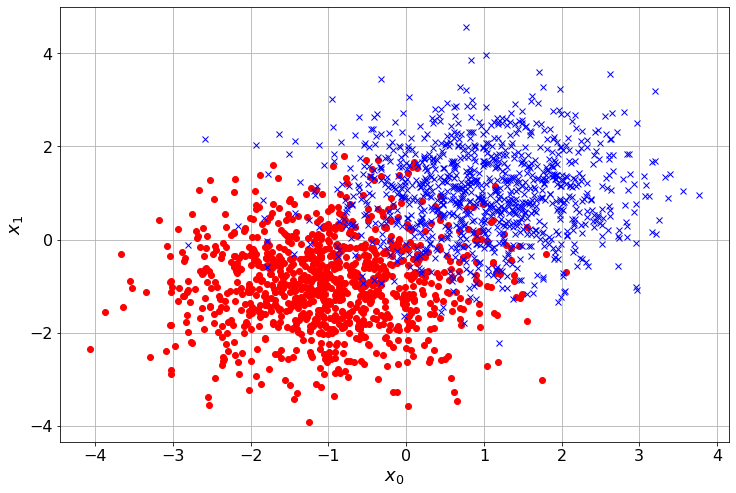

In [3]:
x,y = generate_red_and_blue_normal()

def plot_data(x,y):
    fig,ax=plt.subplots(figsize=(12,8),facecolor='w')
    pos = y>0
    neg = y<1
    ax.plot(x[pos][:,0],x[pos][:,1],marker='o',markersize=6,linestyle='',color='red')
    ax.plot(x[neg][:,0],x[neg][:,1],marker='x',markersize=6,linestyle='',color='blue')
    plt.ylabel('$x_1$ ',fontsize=18)
    plt.xlabel('$x_0$ ',fontsize=18)
    plt.show()
    
plot_data(x,y)

### Using PyTorch

Let's first create PyTorch tensors (= change the datatype!)
Remember we can just give a numpy data into `torch.Tensor` constructor.

In [4]:
import torch
torch_input = torch.Tensor(x).reshape(-1,2) # make sure the shape is (N,2) ... it actually is already so!
torch_label = torch.Tensor(y).reshape(-1,1) # make sure the shape is (N,1)

Next, we define our model in PyTorch. Check points are:

1. Our model should inherit from `torch.nn.Module`
2. Use `torch.nn.Linear` layer. Note bias is already handled so no "bias trick" needed!

As mentioned in the linear regression example, actually, you can avoid defining your model as a class an use `torch.nn.Linear` and `torch.sigmoid` instances. But here we stick with defining a class since that would be how you will write your algorithms for any reasonably non-trivial research problems.

In [5]:

class model0(torch.nn.Module):
    '''
    Logistic regression model.
    We name it model0 as we will make multiple similar models :)
    '''
    def __init__(self, num_features):
        super(model0,self).__init__()
        # Construct a linear operator for the specified number of input features.
        # The output is only 1 feature. We want a constnat term = bias.
        self._linear = torch.nn.Linear(in_features=num_features, out_features=1, bias=True)
        
    def forward(self,x):
        '''
        This should return our prediction (sigmoid output) for a binary classification
        '''
        return torch.sigmoid(self._linear(x))
        
        

Then we define a training loop. Remmeber 3 importnat steps:
1. forward (compute loss)
2. initialize gradients
3. backward (apply gradients)

... and also we introduce
* `torch.nn.BCELoss` ... a binary cross-entropy (BCE) loss
* `torch.optim.SGD` ... SGD optimizer (also used in the previous example of linear regression w/ PyTorch)

In [6]:
def train_torch(torch_input, torch_label, model, num_iterations=100, lr=0.001, optimizer='SGD'):
    # Create a Binary-Cross-Entropy (BCE) loss module
    criterion = torch.nn.BCELoss()
    # Create an optimizer
    optimizer = getattr(torch.optim,optimizer)(model.parameters(),lr=lr)

    # Now we run the training!
    loss_v=[]
    for idx in range(num_iterations): 

        # This is "forward" computation
        prediction = model(torch_input) 

        # Compute the loss, reset the gradients, compute & apply gradients
        loss = criterion(prediction, torch_label) 
        optimizer.zero_grad() 
        loss.backward() 

        # Now let optimizer to "take a step"
        optimizer.step() 

        # Record the loss
        loss_v.append(loss.item())
        
    return loss_v

### Train our model
* Create our model with 2 input features
* Call `train_torch` function with data, label, and our model instance.

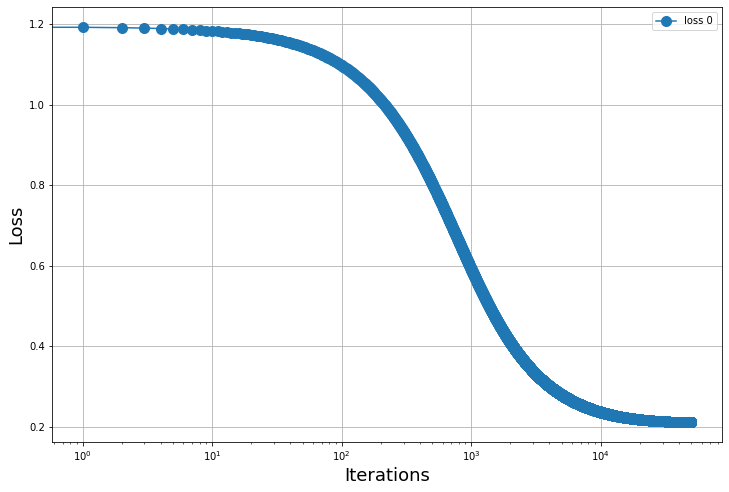

In [7]:
# Create a model 
model = model0(2) 

# Train
loss = train_torch(torch_input,torch_label,model,num_iterations=50000)

def plot_loss(loss_array):
    # Plot the loss
    import matplotlib.pyplot as plt
    %matplotlib inline
    fig,ax = plt.subplots(figsize=(12,8),facecolor='w')

    if len(np.shape(loss_array))==1:
        loss_array = [loss_array]
    for idx,loss in enumerate(loss_array):
        plt.plot(loss,marker='o',markersize=10,label='loss %d' % idx)
    plt.ylabel('Loss',fontsize=18)
    plt.xlabel('Iterations',fontsize=18)
    plt.xscale('log')
    plt.legend()
    plt.show()
    
plot_loss(loss)

### Visualize the results

So the loss looks like it learned something! But how do we retrieve the trained parameters?
Yay Python, we can just directly access within the trained model ;)

In [8]:
print('Dumping the weights...')
print(model._linear.weight)
print('\nDumping the bias term...')
print(model._linear.bias)

Dumping the weights...
Parameter containing:
tensor([[-1.7057, -1.7893]], requires_grad=True)

Dumping the bias term...
Parameter containing:
tensor([0.0786], requires_grad=True)


Let's visualize the decision boundary line, $ax_0+bx_1+c$, like we did before. 

In [9]:
# Convert the torch tensor into a numpy array. 
# First, we have to "detach" any tensor for which gradient is automatically calculated.
a,b = model._linear.weight.detach().numpy().reshape(-1)
# Second, for a bias, we can just extract a single value by calling item() function.
c = model._linear.bias.item()

Then overlay this linear equation on the scatter plot of data points.

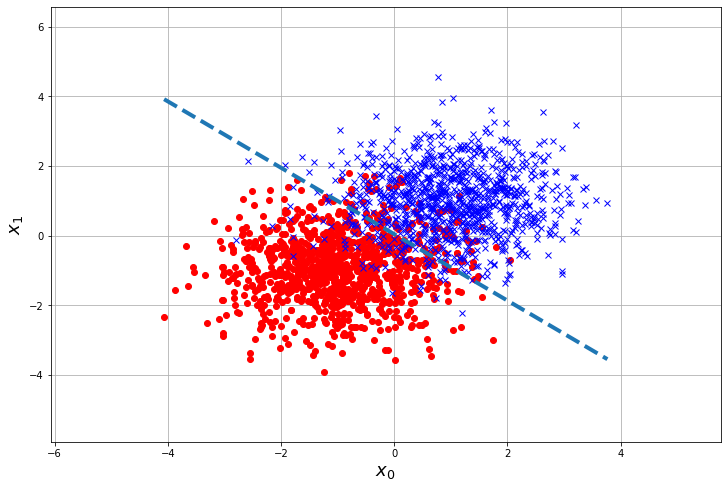

In [10]:
def plot_data_with_lines(x,y,lines):

    fig,ax=plt.subplots(figsize=(12,8),facecolor='w')

    # Draw data points
    pos = y>0
    neg = y<1
    ax.plot(x[pos][:,0],x[pos][:,1],marker='o',markersize=6,linestyle='',color='red')
    ax.plot(x[neg][:,0],x[neg][:,1],marker='x',markersize=6,linestyle='',color='blue')

    # data range
    x0min,x0max=x[:,0].min(),x[:,0].max()
    x1min,x1max=x[:,1].min(),x[:,1].max()
    
    # Draw lines
    if len(np.shape(lines)) == 1:
        lines = [lines]
    for a,b,c in lines:
        x0vals = (x0min,x0max)
        x1vals = (-a/b*x0min-c/b, -a/b*x0max-c/b)
        ax.plot(x0vals,x1vals,linestyle='--',linewidth=4,marker='')

    plt.ylabel('$x_1$ ',fontsize=18)
    plt.xlabel('$x_0$ ',fontsize=18)
    plt.ylim(x1min-2,x1max+2)
    plt.xlim(x0min-2,x0max+2)
    plt.show()

plot_data_with_lines(x,y,[a,b,c])

_Voila!_ This looks reasonable to me :)

## 2. Choice of an optimizer (Exercise 1)

We mentioned that there are more than one falvor of gradient descent optimizer.

Let's give a try to "Adam" optimizer.

1. Re-train your model with `optimizer="Adam"` argument to `train_torch` function and **store the new loss in a differently named attribute** (i.e. don't call it `loss` and overwrite the history from SGD training!).
2. Plot both loss curves together (hint: `plot_loss` function takes an array of array as well)

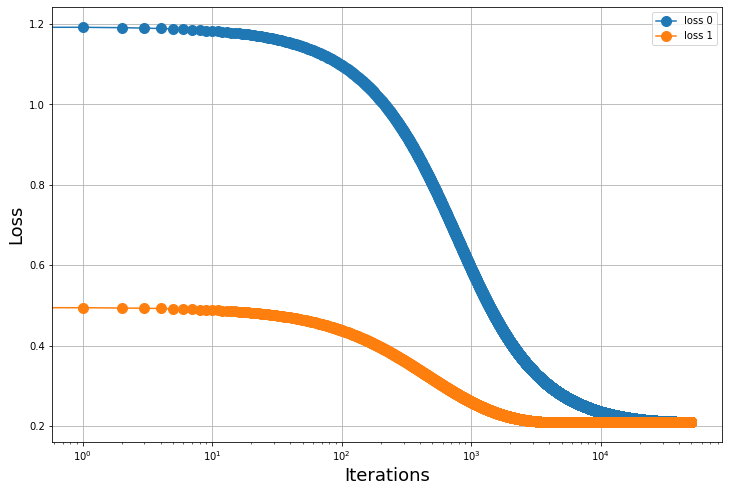

In [11]:
# Create a model 
model = model0(2) 

# Train
loss2 = train_torch(torch_input,torch_label,model,num_iterations=50000,optimizer='Adam')
    
plot_loss([loss,loss2])

We can see `Adam` can flatten the loss curve faster than SGD reaching about the same level of the loss value!

Remember a difference depends on data, task, and your model to be optimized. There is no guaranteed "best solution". However, in practice, "Adam" is a very popular "default" choice for neural networks (later).

## 2. Irregular (not linearly separable) dataset

Let's now make our problem a bit more challenging by modifying our dataset. 

A new data generator puts red and blue points along straight lines of the same slope but with different offsets.

A separation is hence straightforward, except we then re-distribute a half of red points somewhere else.

It's probably the simplest to see by eyes. Let's generate the sample and visualize!


In [12]:

def generate_red_and_blue_irregular(a,b,seed=123,distort=False):
    np.random.seed(seed)
    num_unit=100
    x0 = np.zeros(shape=(num_unit*2),dtype=np.float32)
    x0[:num_unit] = np.arange(0,3,3.0/num_unit)
    x0[num_unit:] = np.arange(2,5,3.0/(num_unit))
    x1 = a*x0 + b + np.random.normal(scale=0.3,size=num_unit*2)
    x1[:num_unit] += 3
    x1[num_unit:] -= 3

    y = np.zeros(shape=(num_unit*2),dtype=np.int32)
    y[:num_unit] = 0
    y[num_unit:] = 1
    
    # if distort, shift some of label 0
    if distort:
        idx=np.arange(num_unit)
        np.random.shuffle(idx)
        idx=idx[:num_unit//2]
        x0[idx] = np.random.normal(size=len(idx),scale=0.3)+2.5
        x1[idx] = np.random.normal(size=len(idx),scale=0.3)
    
    
    data = np.column_stack([x0,x1,y])
    np.random.shuffle(data)

    return data[:,:2],data[:,2]
    


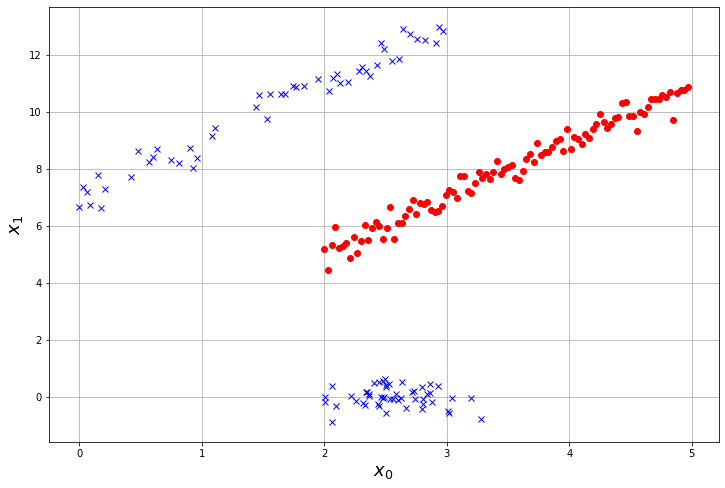

In [13]:
# Use the same data generation function we used before
a,b=2.0,4.0
x,y=generate_red_and_blue_irregular(a,b,distort=True)
plot_data(x,y)

By just look of it, it is clear we cannot separate two populations cleanly with a straight line. It is intuitively a difficult problem: I imagine different line slopes and offset but not very obvious what works the best immediately. A solution needs to wait till the later part of this notebook :)

### Exercise 2
Let's do just another practice.

In [14]:
a,b=2.0,4.0
x,y=generate_red_and_blue_irregular(a,b,distort=False)

torch_input = torch.Tensor(x).reshape(-1,2)
torch_label = torch.Tensor(y).reshape(-1,1)

Above, we just generated another dataset with `distort=False`. 
1. Visualize this dataset
2. Optimize `model0` for with `Adam` with 10000 steps.
3. Visualize the result

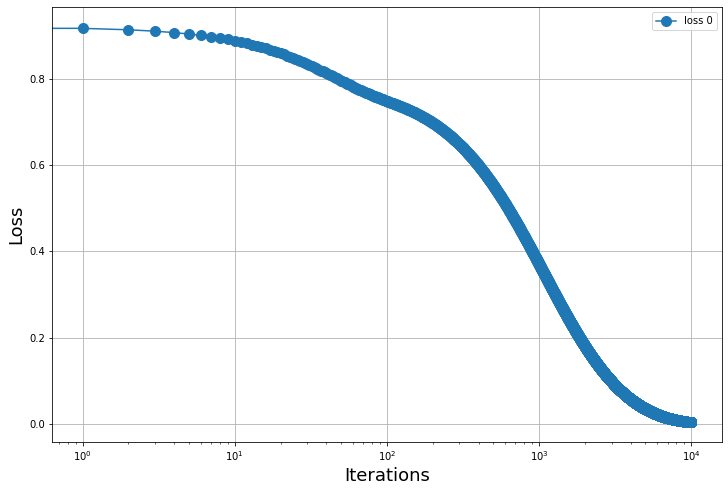

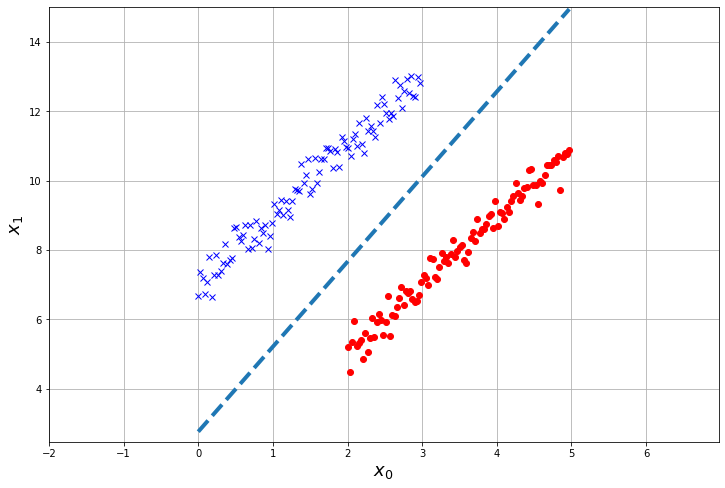

In [15]:
# Create a model 
model = model0(2) 

# Train
loss = train_torch(torch_input,torch_label,model,num_iterations=10000,optimizer='Adam')
    
# Plot the loss
plot_loss(loss)

# Extract line coefficients
a,b = model._linear.weight.detach().numpy().reshape(-1)
c = model._linear.bias.item()

# Plot the line with data
plot_data_with_lines(x,y,[a,b,c])

## 4. Logistic regression on an irregular dataset (Exercise 3)

Let's get back to a _distorted_ dataset and attempt logistic regression!

In [16]:
a,b=2.0,4.0
x,y=generate_red_and_blue_irregular(a,b,distort=True)

torch_input = torch.Tensor(x).reshape(-1,2)
torch_label = torch.Tensor(y).reshape(-1,1)

### Exercise 3
Try the same steps you have done for Exercise 2 with this distorted dataset.

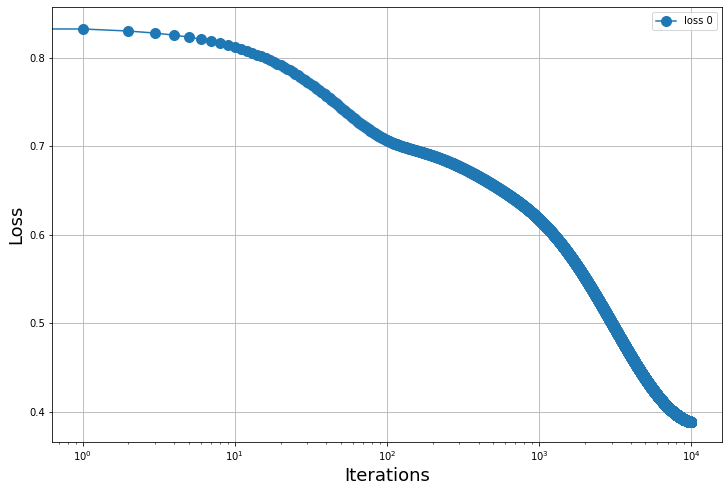

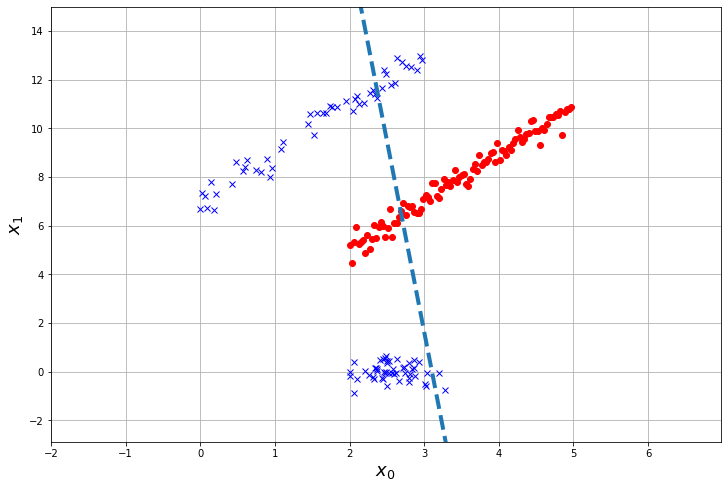

In [17]:
# Create a model 
model = model0(2) 

# Train
loss = train_torch(torch_input,torch_label,model,num_iterations=10000,optimizer='Adam')
    
# Plot the loss
plot_loss(loss)

# Extract line coefficients
a,b = model._linear.weight.detach().numpy().reshape(-1)
c = model._linear.bias.item()

# Plot the line with data
plot_data_with_lines(x,y,[a,b,c])


As expected, not so great :( 

## 5. Logistic regression with two linear layers

During the lecture, we learned about adding a layer may help to linearize a non-linear dataset.

Let's build a new model that contains 2 linear layers. This means we have two instances of `torch.nn.Linear`. Make the second instance, which is our linear classifier, to take 2 inputs so we can visualize as a line in 2D space. That means the first instance of `torch.nn.Linear` should produce 2 output features (imagine the first instance contain 2 linear transformations).


In [18]:
class model1(torch.nn.Module):
    
    def __init__(self,num_features):
        super(model1,self).__init__()
        # Define a linear model with a bias term
        self._linear0  = torch.nn.Linear(num_features,2,bias=True)
        self._linear1  = torch.nn.Linear(2,1,bias=True)
    def forward(self,x):
        return torch.sigmoid(self._linear1(self._linear0(x)))

### Exercise 4
Train this new `model1` with the same dataset that is already generated with 1 additional task:
* Visualize a linear decision boundary like we did before, but plot with data points after the first linear transformation.

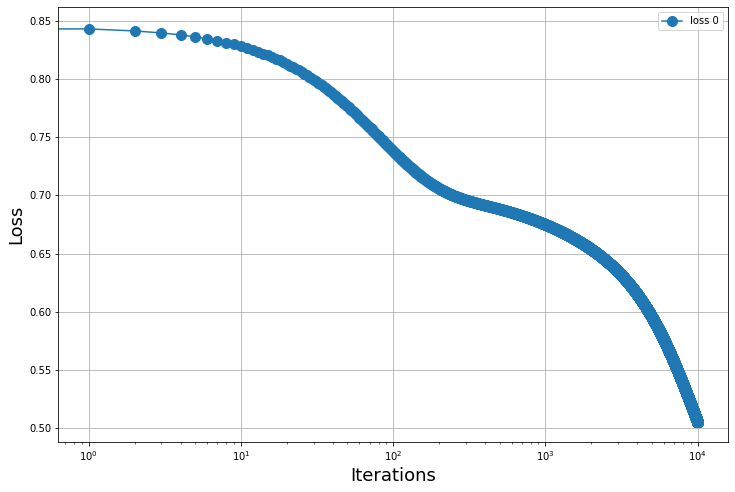

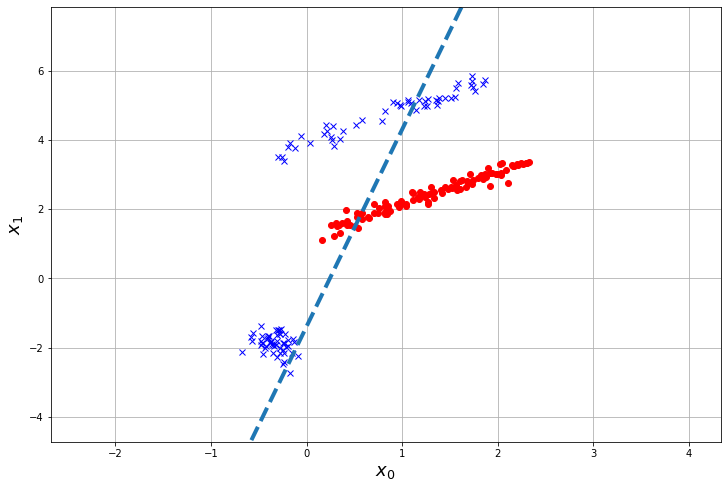

In [19]:
# Create a model 
model = model1(2) 

# Train
loss = train_torch(torch_input,torch_label,model,num_iterations=10000)

# Plot loss
plot_loss(loss)

# Apply the first linear transformation
pts=model._linear0(torch_input).detach().numpy()

# Extract the decision boundary (line) parameters
a,b = model._linear1.weight.detach().numpy().reshape(-1)
c=model._linear1.bias.item()

# Plot
plot_data_with_lines(pts,y,[a,b,c])

You should see the result did not improve much compared to a single linear transformation (i.e. `model0`). That's because it's hard to distort the location of these data points, which is critical for whether a linear model works well or not, too much with only a linear transformation. 

That's right... what we have been lacking is a non-linearity.

So let's build `model2` with a non-linear activation function `torch.nn.LeakyReLU`.

## 6. Non-linear activation function (Exercise 5)

1. Design `model2` with `torch.nn.LeakyReLU` inserted between two linear layers
2. Train the model with `Adam` and 10000 iterations
3. Visualize the input data and two lines from the first 


In [20]:
class model2(torch.nn.Module):
    
    def __init__(self,num_features):
        super(model2,self).__init__()
        # Define a linear model with a bias term
        self._linear0  = torch.nn.Linear(num_features,2,bias=True)
        self._linear1  = torch.nn.Linear(2,1,bias=True)
        self._relu     = torch.nn.LeakyReLU()
    def forward(self,x):
        return torch.sigmoid(self._linear1(self._relu(self._linear0(x))))

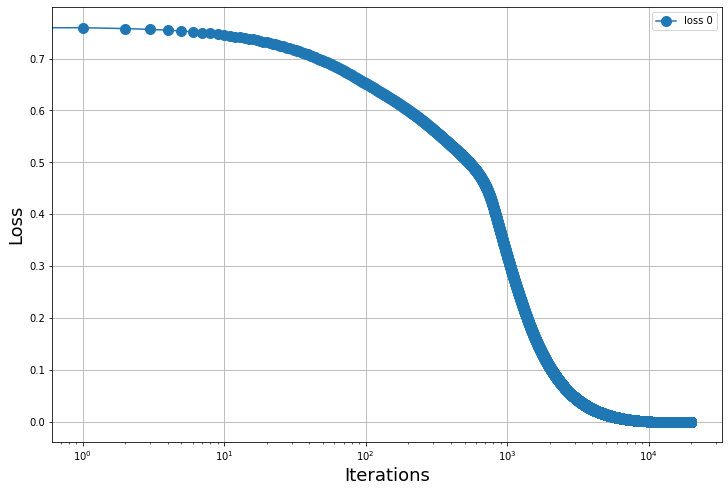

In [21]:
# Create a model 
model = model2(2) 

# Train
loss = train_torch(torch_input,torch_label,model,num_iterations=20000,optimizer='Adam')

plot_loss(loss)

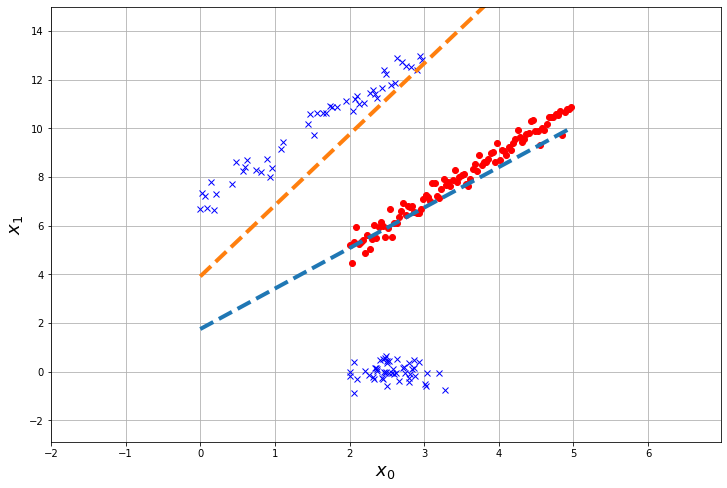

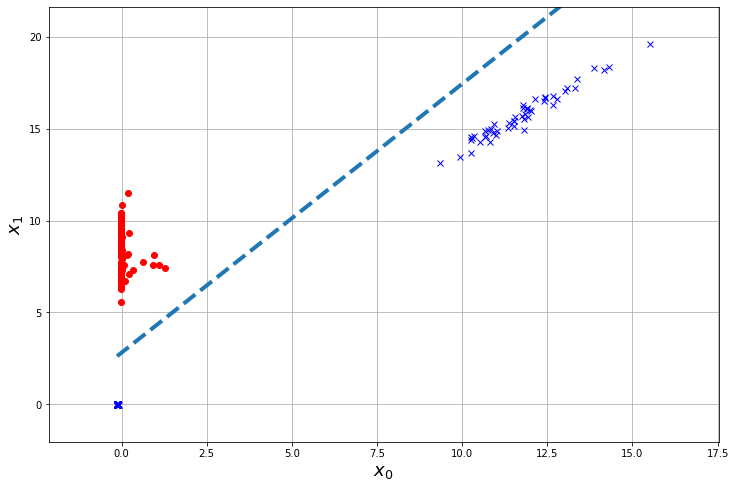

In [22]:


a0,b0 = model._linear0.weight.detach().numpy()[0].reshape(-1)
c0=model._linear0.bias.detach().numpy()[0]

a1,b1 = model._linear0.weight.detach().numpy()[1].reshape(-1)
c1=model._linear0.bias.detach().numpy()[1]

plot_data_with_lines(x,y,[[a0,b0,c0],[a1,b1,c1]])

pts=model._relu(model._linear0(torch_input)).detach().numpy()
a,b = model._linear1.weight.detach().numpy().reshape(-1)
c=model._linear1.bias.item()

plot_data_with_lines(pts,y,[[a,b,c]])


## Closing

By now, hopefully you feel familiar with a logistic regression using a linear model! and also getting used to how to define a model, optimize, and access the output using PyTorch. We will move onto a bit more complex models in the next notebooks.